## Big Data and Large-Scale Computing Project


## **Yelp Recommender**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). 


#### ** This Project will cover: **
*  *Part 1 :* Exploratory Data Analysis.
*  *Part 2 :* Prediction using tree ensemble methods.
*  *Part 3 :* Collaborative filtering for recommendation.
*  *Part 4 :* Word2Vec for text reviews.
*  *Part 5 :* Frequent pattern mining using FP-Growth algorithm.


# ** Part 0: Load the datasets required for the project **

Load four datasets for this project. In addition to the four datasets, I also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Create the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.7-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [3]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/pylon5/ci5619p/kushagra/yelp_academic_dataset_business_small.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

10000
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [4]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/pylon5/ci5619p/kushagra/yelp_academic_dataset_user_small.json')
print (users_rdd.count())
print (users_rdd.take(2))

10000
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17U

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/pylon5/ci5619p/kushagra/yelp_academic_dataset_checkin_small.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

10000
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/pylon5/ci5619p/kushagra/yelp_academic_dataset_review_pittsburgh_small.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

10000
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, load two name lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/pylon5/ci5619p/benh/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/pylon5/ci5619p/benh/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  10000
Number of users:  10000
Number of checkins:  10000
Number of reviews:  10000


Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
from operator import add

categories = businesses_rdd.flatMap(lambda x: x['categories']).map(lambda x: (x, 1))
top5 = categories.reduceByKey(add).takeOrdered(5, key=lambda x: -x[1])
top5

[('Restaurants', 3216),
 ('Shopping', 1810),
 ('Food', 959),
 ('Health & Medical', 712),
 ('Beauty & Spas', 704)]

Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
cities = businesses_rdd.map(lambda x: (x['city'], 1))
top5 = cities.reduceByKey(add).takeOrdered(5, key=lambda x: -x[1])
top5

[('Phoenix', 1954),
 ('Las Vegas', 1337),
 ('Charlotte', 1278),
 ('Pittsburgh', 979),
 ('Scottsdale', 640)]

Plot the histogram of stars received by businesses.

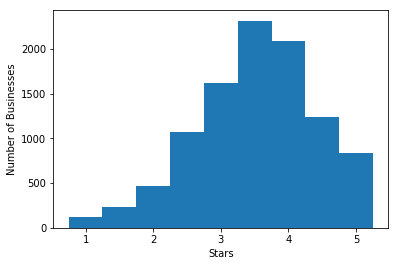

In [11]:
businesses_stars_counts = businesses_rdd.map(lambda x: (x['stars'])).collect()
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')


Plot the histogram of number of reviews received by businesses.

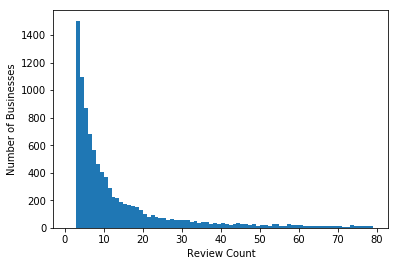

In [12]:
businesses_review_counts = businesses_rdd.map(lambda x: (x['review_count'])).collect()

plt.hist(businesses_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

Plot the above histogram but now on a log-log scale. 
<br>It can be seen from the orignal graph that the lower number (in terms of review counts here) dominates the distribution. When we plot it in log-log form, the relationship between review_count and # of businesses is appromiately linear, and the slope of the it corresponds to the power law exponent. 


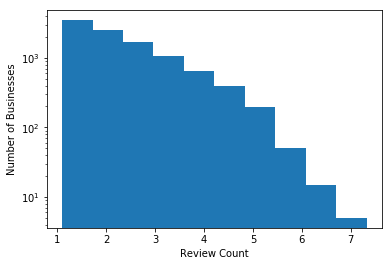

In [13]:
businesses_review_counts = businesses_rdd.map(lambda x: (x['review_count'])).collect()

plt.hist(np.log(businesses_review_counts), log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

Plot the histogram of number of reviews written by users.

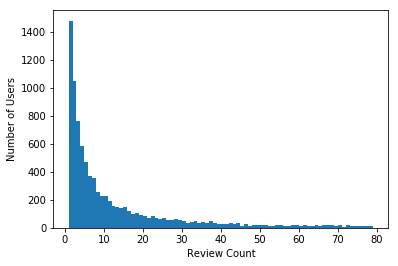

In [15]:
users_review_counts = users_rdd.map(lambda x: (x['review_count'])).collect()

plt.hist(users_review_counts, bins=range(1,80))
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

Plot the above histogram but now on a log-log scale. 
<br>It can be seen from the orignal graph that the lower number (in terms of review counts here) dominates the distribution. When we plot it in log-log form, the inverse exponential relationship between review_count and # of users is more obvius.

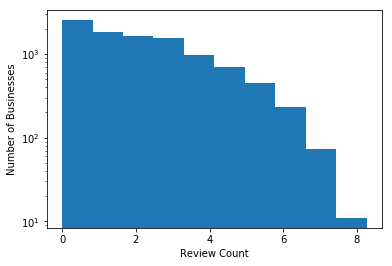

In [16]:
users_review_counts = users_rdd.map(lambda x: (x['review_count'])).filter(lambda x: x > 0).collect()

plt.hist(np.log(users_review_counts), log=True)
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

Plot the histogram of number of friends a Yelp user has.

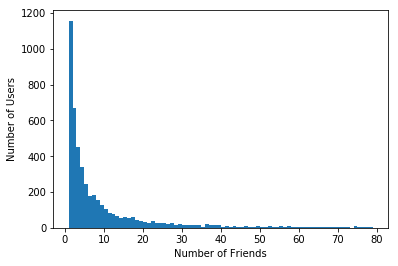

In [17]:
user_friend_counts = users_rdd.map(lambda x: (len(x['friends']))).collect()

plt.hist(user_friend_counts, bins=range(1,80))
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

Plot the above histogram but now on a log-log scale.
<br>It can be seen from the orignal graph that the lower number (in terms of # of friends here) dominates the distribution, and there's an inverse exponential relationship. When we plot it in log-log form, the relationship between review_count and # of users is appromiately linear, and the slope of it corresponds to the power law exponent. 


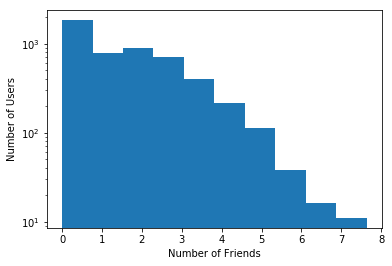

In [18]:
user_friend_counts = users_rdd.map(lambda x: (len(x['friends']))).filter(lambda x: x > 0).collect()

plt.hist(np.log(user_friend_counts), log=True)
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

Plot the histogram of number of fans a Yelp user has.

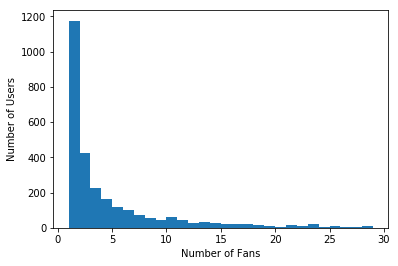

In [19]:
users_fan_counts = users_rdd.map(lambda x: (x['fans'])).collect()

plt.hist(users_fan_counts, bins=range(1,30))
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

Plot the above histogram but now on a log-log scale.
<br>It can be seen from the orignal graph that the lower number (in terms of # of fans here) dominates the distribution, and there's an inverse exponential relationship. When we plot it in log-log form, the relationship between review_count and # of users is appromiately linear, and the slope of it corresponds to the power law exponent. 

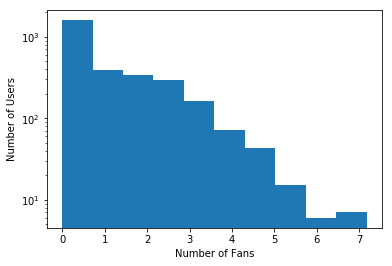

In [20]:
users_fan_counts = users_rdd.map(lambda x: (x['fans'])).filter(lambda x: x > 0).collect()

plt.hist(np.log(users_fan_counts), log=True)
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

Plot the histogram of number of checkins per Yelp business.

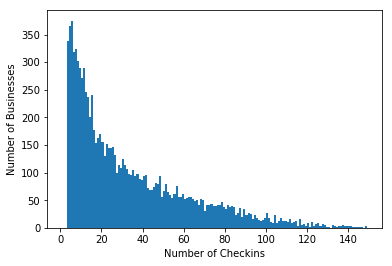

In [21]:
business_checkin_counts = checkins_rdd.map(lambda x: len(x["checkin_info"])).collect()

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

Plot the above histogram but now on a log-log scale.
<br>After log-log transformation, there's no inverse exponential relationship or negative linear relationship between # of business checkins and # of businesses, which suggests # checkins does not vary as the power of # of business.

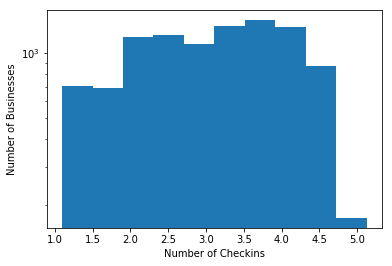

In [22]:
business_checkin_counts = checkins_rdd.map(lambda x: len(x["checkin_info"])).collect()

plt.hist(np.log(business_checkin_counts),log=True)
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. 

In [23]:
max_checkin_count = checkins_rdd.map(lambda x: len(x["checkin_info"])).max()
business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x: len(x["checkin_info"]) == max_checkin_count) \
    .map(lambda x: x["business_id"]).collect()
len(business_ids_with_max_checkins)

3

In [24]:
business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x: x["business_id"] in business_ids_with_max_checkins) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('Charlotte Douglas International Airport', 'Charlotte'),
 ('Phoenix Sky Harbor International Airport', 'Phoenix'),
 ('Pho Kim Long', 'Las Vegas')]

The above list sees much higher checkins than other businesses in the dataset.
<br>The first two are airport hotels, and the third one is restaurant in Las Vegas. It could be that those high # of checkins are brought by large flow of customers. For example, if a large amount of people visit those three locations very frequently, say for business or holiday travels, then it will increase the # of checkins of those busiensses. It can be seen that location is pretty important here.

Plot a histogram of the stars associated with business reviews.

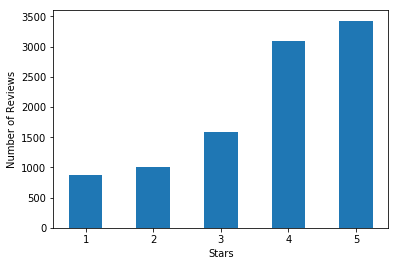

In [25]:
review_stars_counts = reviews_rdd.map(lambda x: (x['stars'])).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

Plot a histogram of the number of reviews written per Yelp user.

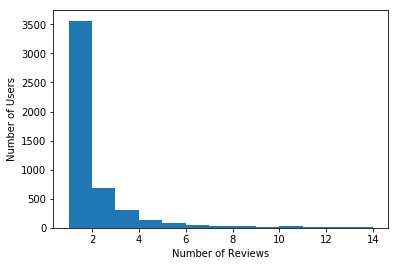

In [26]:
user_review_counts = list(reviews_rdd.map(lambda x: x["user_id"]).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

Plot a histogram of the number of reviews written per Yelp business.

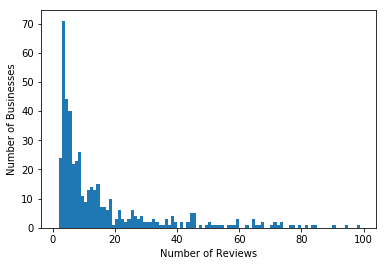

In [27]:
business_review_counts = list(reviews_rdd.map(lambda x: x["business_id"]).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)])
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

Plot a histogram of the number of useful votes received by Yelp reviews.

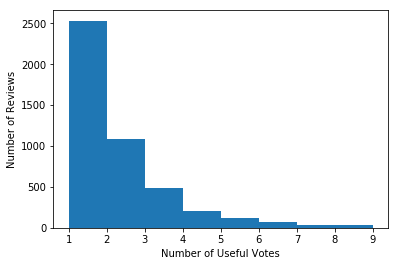

In [28]:
review_useful_counts = reviews_rdd.map(lambda x: x["votes"]["useful"]).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

Plot a histogram of the number of funny votes received by Yelp reviews.

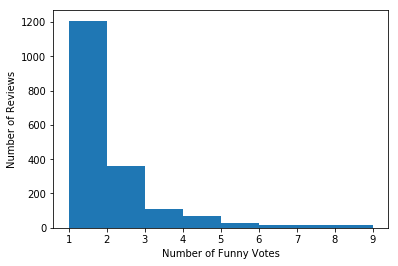

In [29]:
review_funny_counts = reviews_rdd.map(lambda x: x["votes"]["funny"]).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

Plot a histogram of the number of cool votes received by Yelp reviews.

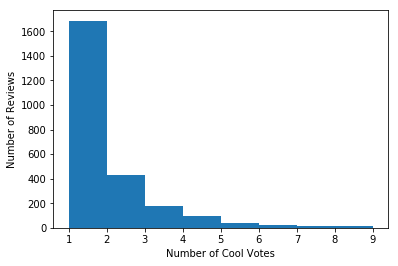

In [30]:
review_cool_counts = reviews_rdd.map(lambda x: x["votes"]["cool"]).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)])
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

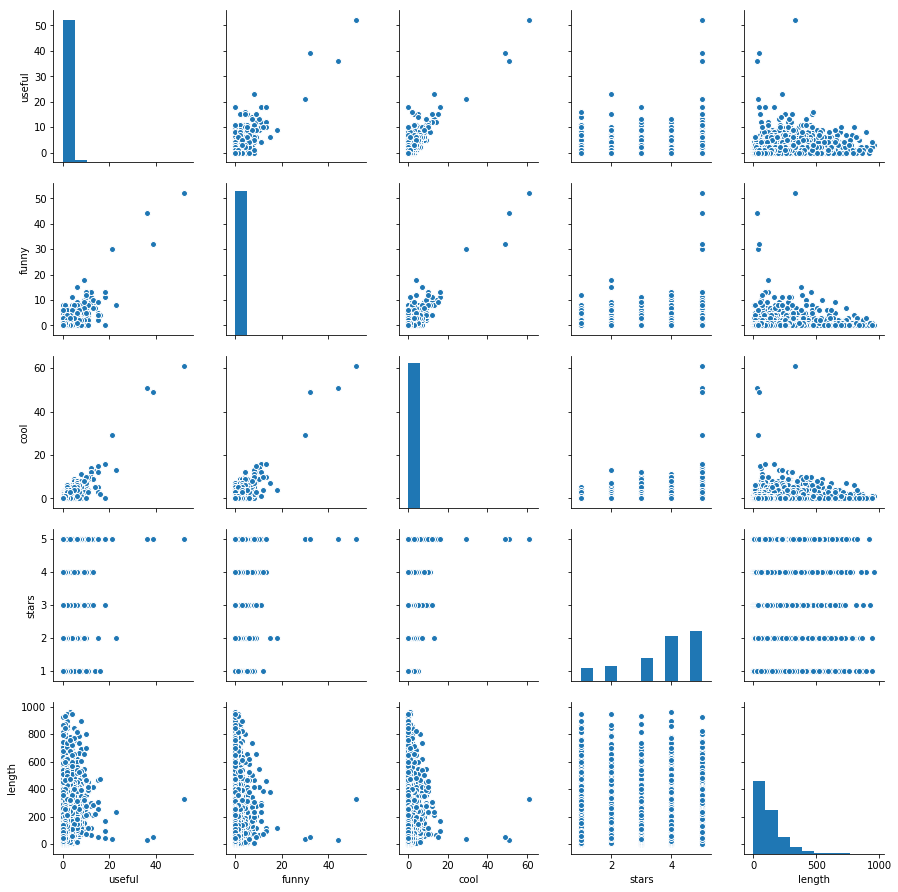

In [31]:
review_votes_length = reviews_rdd.map(lambda x: (x["votes"]["useful"],
                                                 x["votes"]["funny"],
                                                 x["votes"]["cool"],
                                                 x["stars"],
                                                 len(x["text"].split(" ")))).collect()

review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

Plot the distribution of the number of words used by males and females in their reviews. I will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [32]:
male_users = users_rdd.filter(lambda x : x["name"] in male_names)
female_users = users_rdd.filter(lambda x : x["name"] in female_names)

male_user_ids = male_users.map(lambda x : x["user_id"]).collect()
female_user_ids = female_users.map(lambda x : x["user_id"]).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

4592
4697
10000


I can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [33]:
male_reviews = reviews_rdd.filter(lambda x: x["user_id"] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x: x["user_id"] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x: len(x.split(" ")))
female_word_count = female_reviews.map(lambda x: len(x.split(" ")))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  102.71875 136.15032679738562


<br>The code below calculates the distributions of review lengths for males and female reviewers and plots them. 
<br>On average, female users tends to have longer review length as compared to male users. From the distribution graph, it can be seen that female users are more spread out in review length compared to male users, and male users give more reviews compared to female users.

In [34]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

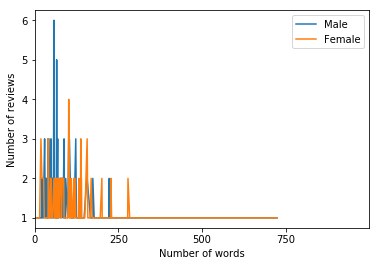

In [35]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, I will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [36]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

Calculate word counts from text reviews below.

In [37]:
max_words = 50000

all_reviews = reviews_rdd.map(lambda x : (x['text'], x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x: x[0].split(" ")).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)

Number of unique words:  50000


I will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. 

In [38]:
word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i: unique_words[i] for i in range(len(unique_words))}

Obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [39]:
doc_vectors = all_reviews.map(lambda x: (x[1], x[0].split())).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x: LabeledPoint(x[0], x[1]))
print(doc_vectors.count())
print(doc_vectors.take(2))

10000
[LabeledPoint(3.0, [20078.0,3582.0,29169.0,183.0,801.0,2874.0,48.0,0.0,545.0,183.0,864.0,39.0,20.0,10245.0,1163.0,104.0,7.0,345.0,5.0,3408.0,0.0,460.0,3806.0,17.0,16.0,865.0,12.0,0.0,29170.0,15764.0,5454.0,17.0,20079.0,7.0,3696.0,42.0,17.0,16.0,865.0,10.0,10246.0,16.0,3911.0,258.0,183.0,118.0,9.0,183.0,7.0,314.0,1653.0,13.0,16.0,29171.0,1.0,22.0,5.0,4416.0,5.0,0.0,29172.0,186.0,1552.0,9220.0,39.0,0.0,4577.0,235.0,104.0,183.0,7.0,3912.0,1163.0,7.0,345.0,5.0,260.0,25.0,16.0,865.0,1.0,48.0,0.0,6069.0,1.0,2562.0,0.0,718.0,3913.0,275.0,4139.0,20080.0,261.0,86.0,683.0,56.0,2.0,29173.0,13235.0,20081.0,7845.0,13.0,42.0,594.0,3697.0,5213.0,5.0,105.0,161.0,0.0,1126.0,917.0,346.0,17.0,16.0,29174.0,159.0,1413.0,408.0,29175.0]), LabeledPoint(1.0, [384.0,434.0,10.0,290.0,850.0,231.0,5.0,4578.0,9.0,40.0,237.0,1005.0,403.0,6.0,0.0,433.0,79.0,13236.0,60.0,485.0,90.0,7310.0,20082.0,5214.0,0.0,15765.0,84.0,4579.0,5.0,113.0,434.0,207.0,850.0,231.0,10.0,408.0,5.0,2562.0,106.0,662.0,291.0,20.0,235.0,4

Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [40]:
weights = [.8, .2]
seed = 0

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit(weights, seed)

Implement the baseline predictor which always outputs the most common value of funny votes.

In [41]:
most_common_prediction = doc_vectors_train.map(lambda x: (x.label,1)).reduceByKey(lambda x,y: x+y).first()[0]
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 1.0905066404328578
Learned baseline prediction:  0.0


Use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5.

In [42]:
dt_model = DecisionTree.trainRegressor(doc_vectors_train, categoricalFeaturesInfo={}, impurity='variance', maxDepth=5)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

# ** Part 3: Collaborative filtering for recommendation **

In this section, I will use collaborative filtering to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [43]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

Determine the unique user and business IDs that appear in the reviews data. This will helps in building dictionaries for mapping the user/business IDs to unique integer indices. 

In [44]:
review_user_ids = reviews_rdd.map(lambda x: x["user_id"]).distinct().collect()
review_business_ids = reviews_rdd.map(lambda x: x["business_id"]).distinct().collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [45]:
ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x["user_id"]], 
                                               business_to_index_dict[x["business_id"]], float(x["stars"])))
print(ratings_rdd.take(2))

[Rating(user=1115, product=226, rating=5.0), Rating(user=1997, product=226, rating=2.0)]


Randomly split data into 80% train and 20% validation set.

In [46]:
ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit([0.8, 0.2])

For a succession of ranks, I will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). I will use the model to obtain train as well as validation RMSE for each rank. 

In [47]:
numIterations=10
ranks = list(range(10, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings_rdd_train, rank, numIterations)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=10) = Train 0.19459805960568488, Validation 3.669185674790717
Root Mean Squared Error (rank=30) = Train 0.167650125652771, Validation 2.3436189431747905
Root Mean Squared Error (rank=50) = Train 0.16748987031176507, Validation 1.9676566384557708
Root Mean Squared Error (rank=70) = Train 0.16745037506546867, Validation 1.9601208312731362
Root Mean Squared Error (rank=90) = Train 0.16743888322370326, Validation 1.9067495018712322
Root Mean Squared Error (rank=110) = Train 0.1674441904596554, Validation 1.9326855470396271
Root Mean Squared Error (rank=130) = Train 0.16744353953334834, Validation 1.8662559820055207
Root Mean Squared Error (rank=150) = Train 0.1674369327937396, Validation 1.9110744881462467
Root Mean Squared Error (rank=170) = Train 0.16743389995785288, Validation 1.8922483734134976
Root Mean Squared Error (rank=190) = Train 0.16745243335752874, Validation 1.852363065097604


Plot the train and validation RMSE versus the rank. 
<br>Based on this plot, it seems that choosing a rank between 40 and 50 will give us most drop in rmse. So, maybe here 45 would be a good choice. Also, since rmse becomes flatter as choice of rank increases, we'd expect same results if conduct a more extensive hyperparameter search at larger ranks. Thus, the results should be conclusive.

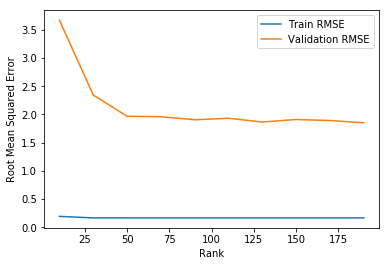

In [48]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Word2Vec for text reviews **

In this section, I will fit a Word2Vec model to the Yelp reviews text. 

In [49]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [50]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [51]:
word2vec_model = Word2Vec().setVectorSize(10).setSeed(42).setNumIterations(10).fit(review_docs)

Examine what words are closely associated with some example words. 

In [52]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['filler', 'pan', 'sugary', 'mayo', 'powder']
Words most similar to  pepper  :  ['onions', 'mushrooms', 'relish', 'sausage', 'caramelized']
Words most similar to  restaurant  :  ['scene', 'soho', 'landmark', 'location', 'steakhouses']
Words most similar to  italian  :  ['standpoint', 'traditional', 'chock', 'american', 'hamburger']
Words most similar to  indian  :  ['superior', 'chinese', 'comfort', 'joint', 'unlike']
Words most similar to  chinese  :  ['se', 'popular', 'indian', 'japanese', 'joint']
Words most similar to  direction  :  ['nfl', 'leading', 'models', 'holmes', 'rite']
Words most similar to  pittsburgh  :  ['nyc', 'bloomfield', 'pgh', 'va', 'boston']
Words most similar to  burgh  :  ['suburbs', 'best', 'los', 'dormont', 'pittsburgh']
Words most similar to  city  :  ['regent', 'plaza', 'oakland', 'suburbs', 'square']
Words most similar to  location  :  ['neighborhood', 'dead', 'restaurant', 'scene', 'theater']
Words most similar to  cmu  :  

For example, "pittsburhg" and "pgh" are very good synonyms, where as example like "cmu" and "hunt" are not good substitutes. However, some of the paris may not be good substitute for the orignally supplied work, but the are asoociated and make sense to appear together in descriptions such as "pizza" and "italian".

# ** Part 5: Frequent pattern mining using FP-Growth algorithm **

In this section, I will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, I can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [53]:
from pyspark.mllib.fpm import FPGrowth

Perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [54]:
business_categories = businesses_rdd.map(lambda x: x["categories"])

fpgrowth_model = FPGrowth.train(business_categories, minSupport=0.01, numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Fast Food', 'Restaurants'], freq=496)
FreqItemset(items=['Bars', 'Nightlife'], freq=464)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=455)
FreqItemset(items=['Fashion', 'Shopping'], freq=423)
FreqItemset(items=['Pizza', 'Restaurants'], freq=381)
FreqItemset(items=['Mexican', 'Restaurants'], freq=352)
FreqItemset(items=['Auto Repair', 'Automotive'], freq=349)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=345)
FreqItemset(items=['Home & Garden', 'Shopping'], freq=309)
FreqItemset(items=['Doctors', 'Health & Medical'], freq=304)
FreqItemset(items=['Chinese', 'Restaurants'], freq=300)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=297)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=278)
FreqItemset(items=['Bars', 'Restaurants'], freq=278)
FreqItemset(items=['Burgers', 'Restaurants'], freq=275)
FreqItemset(items=['Hotels & Travel', 'Event Planning & Services'], freq=268)
FreqItemset(items=['Hotels', 'Hotels & Travel'], fre